In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import pandas_datareader.data as web
import pandas as pd
import numpy as np

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')

In [46]:
def plot_correlogram(x, lags=None, title=None, ylim=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        if ylim:
            axes[1][0].set_ylim(ylim)
            axes[1][1].set_ylim(ylim)
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

## Import Data

In [6]:
air_passenger_df = pd.read_csv('AirPassengers.csv')
bitcoin_df = pd.read_csv('BITSTAMP_BTCUSD, 1D.csv') 
# co2_df = pd.read_csv('co2_daily_mlo.csv')
london_weather_df = pd.read_csv('london_weather.csv')
sunspot_df = pd.read_csv('daily_sunspots_time_series_1850-01_2025-01.csv')

In [7]:
print(air_passenger_df.head())
print(bitcoin_df.head())
print(london_weather_df.head())
print(sunspot_df.head())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
         time   open   high    low  close       Plot  \
0  1721779200  65943  67112  65117  65376  29.039539   
1  1721865600  65363  66135  63424  65796  29.092810   
2  1721952000  65794  68214  65712  67921  29.070914   
3  1722038400  67952  69404  66637  67892  29.070914   
4  1722124800  67837  68298  67064  68264  29.070914   

   Lagged Liquidity (12 weeks)     Plot.1       Volume  
0                    29.176500  29.039539  1796.815320  
1                    29.160413  29.092810  2022.662134  
2                    29.099673  29.070914  1786.033940  
3                    29.098550  29.070914  1875.179406  
4                    29.156438  29.070914   861.958033  
       date  cloud_cover  sunshine  global_radiation  max_temp  mean_temp  \
0  19790101          2.0       7.0              52.0       2.3       -4.1   
1  19790102          6.

In [8]:
# model='additive' where magnitude remains constant like temp
# model='multiplicative' where effects scale with the trend such as stocks or GDP

air_passenger_df['Month'] = pd.to_datetime(air_passenger_df['Month'])
air_passenger_df.set_index('Month', inplace=True)
air_passenger_components = tsa.seasonal_decompose(air_passenger_df['#Passengers'], model='additive')

In [9]:
air_passenger_2_df = pd.read_csv('AirPassengers.csv')
air_passenger_2_df['Month'] = pd.to_datetime(air_passenger_2_df['Month'])
air_passenger_2_df.set_index('Month', inplace=True)
air_passenger_2_components = tsa.seasonal_decompose(air_passenger_2_df['#Passengers'], model='multiplicative')

In [10]:
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['time'], unit='s')
bitcoin_df.set_index('datetime', inplace=True)
bitcoin_df.drop(columns=['time', 'open', 'high', 'low', 'Plot', 'Lagged Liquidity (12 weeks)', 'Plot.1', 'Volume'], inplace=True)
bitcoin_components = tsa.seasonal_decompose(bitcoin_df['close'], model='multiplicative')

In [11]:
london_weather_df['date'] = pd.to_datetime(london_weather_df['date'], format='%Y%m%d')
london_weather_df.set_index('date', inplace=True)
london_weather_df.dropna(inplace=True)
london_weather_df.drop(columns=['cloud_cover', 'sunshine', 'global_radiation','max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth'], inplace=True)
london_weather_df.head()
london_weather_components = tsa.seasonal_decompose(london_weather_df['mean_temp'], model='additive', period=365)

In [12]:
sunspot_df['date'] = pd.to_datetime(sunspot_df['date'])
sunspot_df.set_index('date', inplace=True)
sunspot_df.drop(columns=['year', 'month', 'day', 'date_frac', 'std', 'nobs', 'indicator'], inplace=True)
sunspot_components = tsa.seasonal_decompose(sunspot_df['counts'], model='additive')

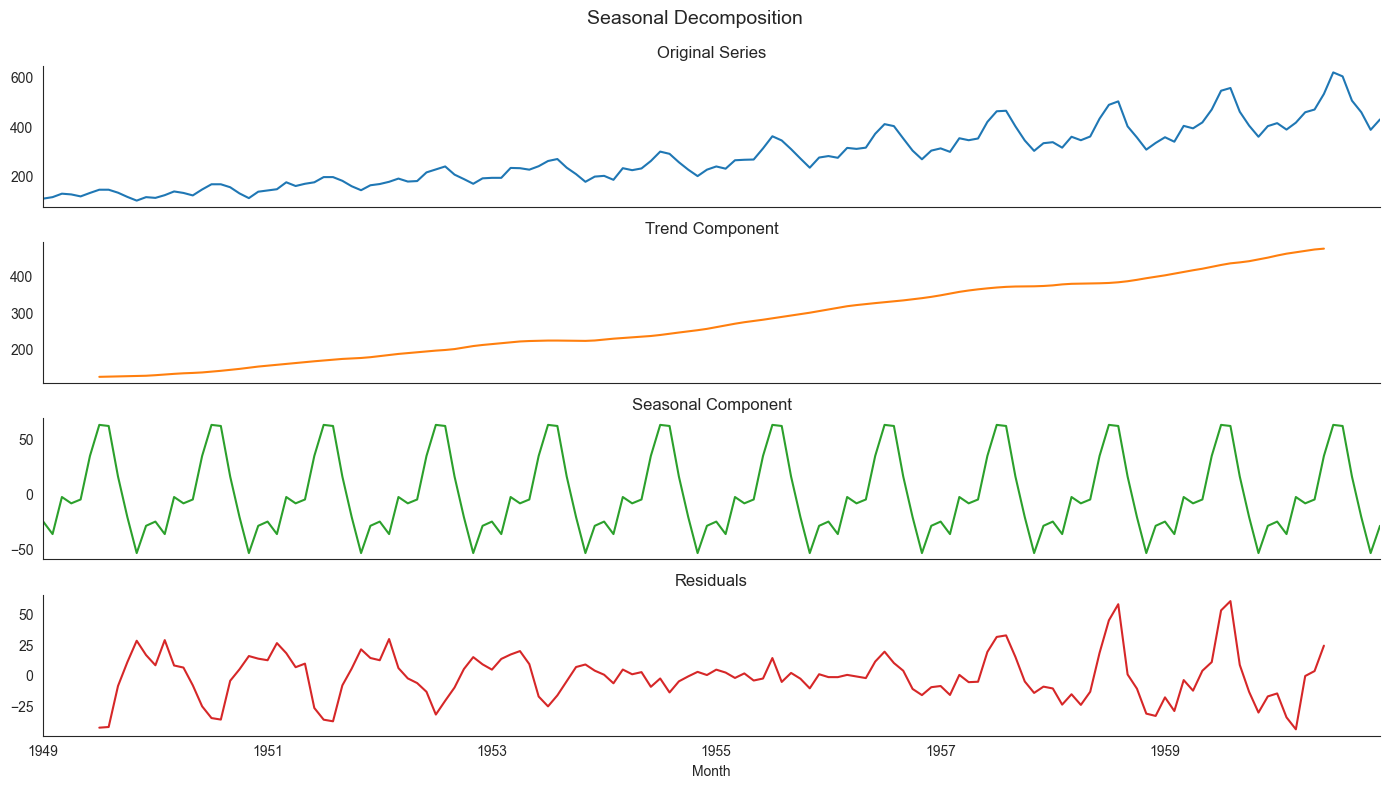

In [13]:
ts = (air_passenger_df['#Passengers'].to_frame('Original')
      .assign(Trend=air_passenger_components.trend)
      .assign(Seasonality=air_passenger_components.seasonal)
      .assign(Residual=air_passenger_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

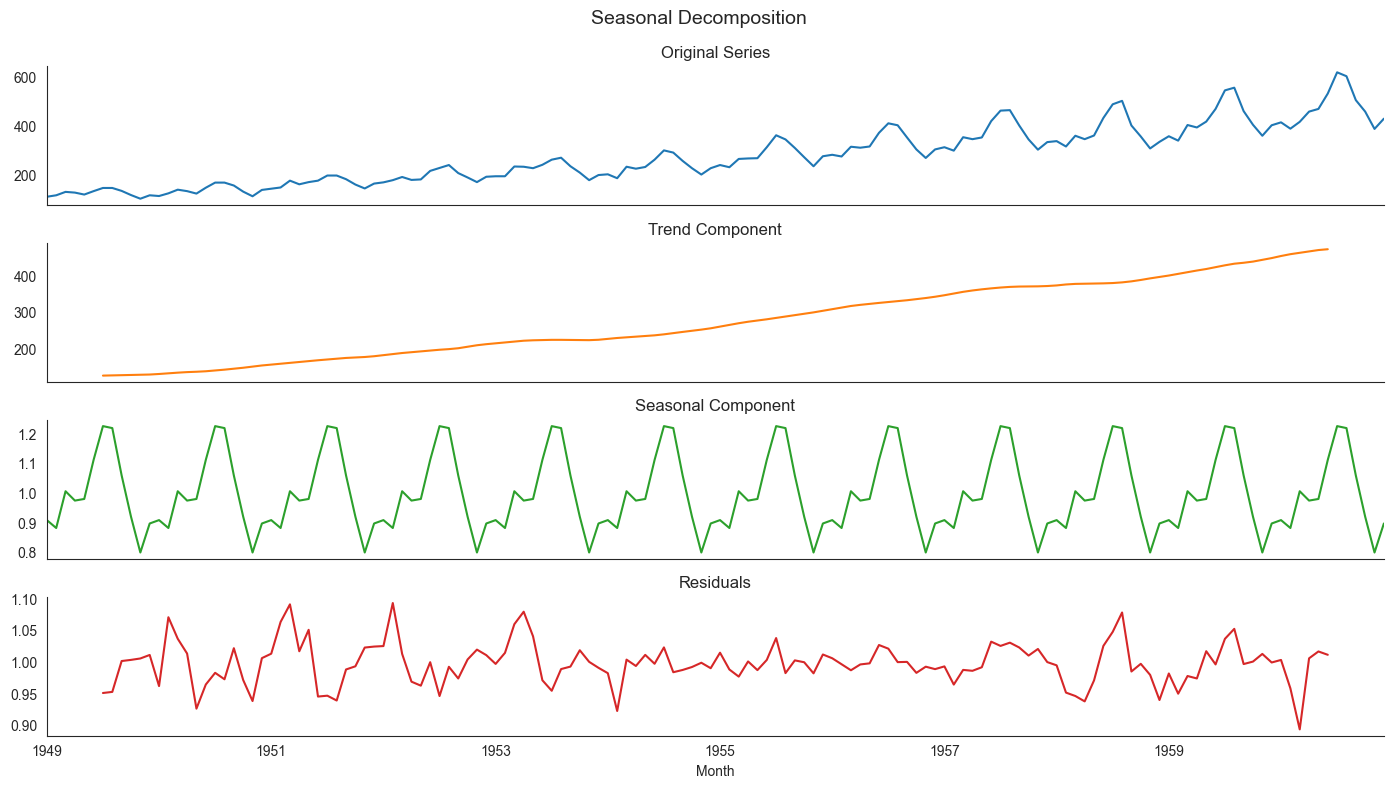

In [14]:
ts = (air_passenger_2_df['#Passengers'].to_frame('Original')
      .assign(Trend=air_passenger_2_components.trend)
      .assign(Seasonality=air_passenger_2_components.seasonal)
      .assign(Residual=air_passenger_2_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

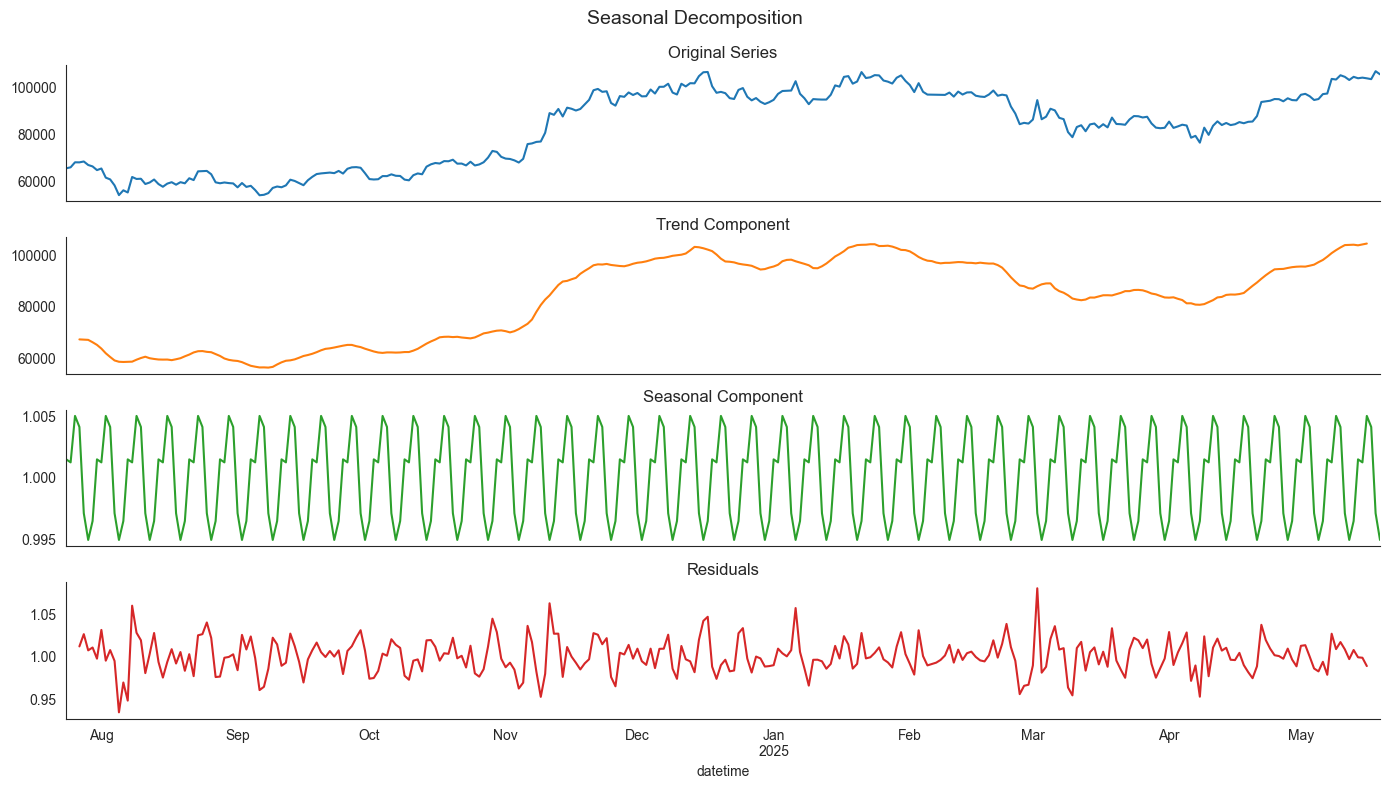

In [15]:
ts = (bitcoin_df['close'].to_frame('Original')
      .assign(Trend=bitcoin_components.trend)
      .assign(Seasonality=bitcoin_components.seasonal)
      .assign(Residual=bitcoin_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

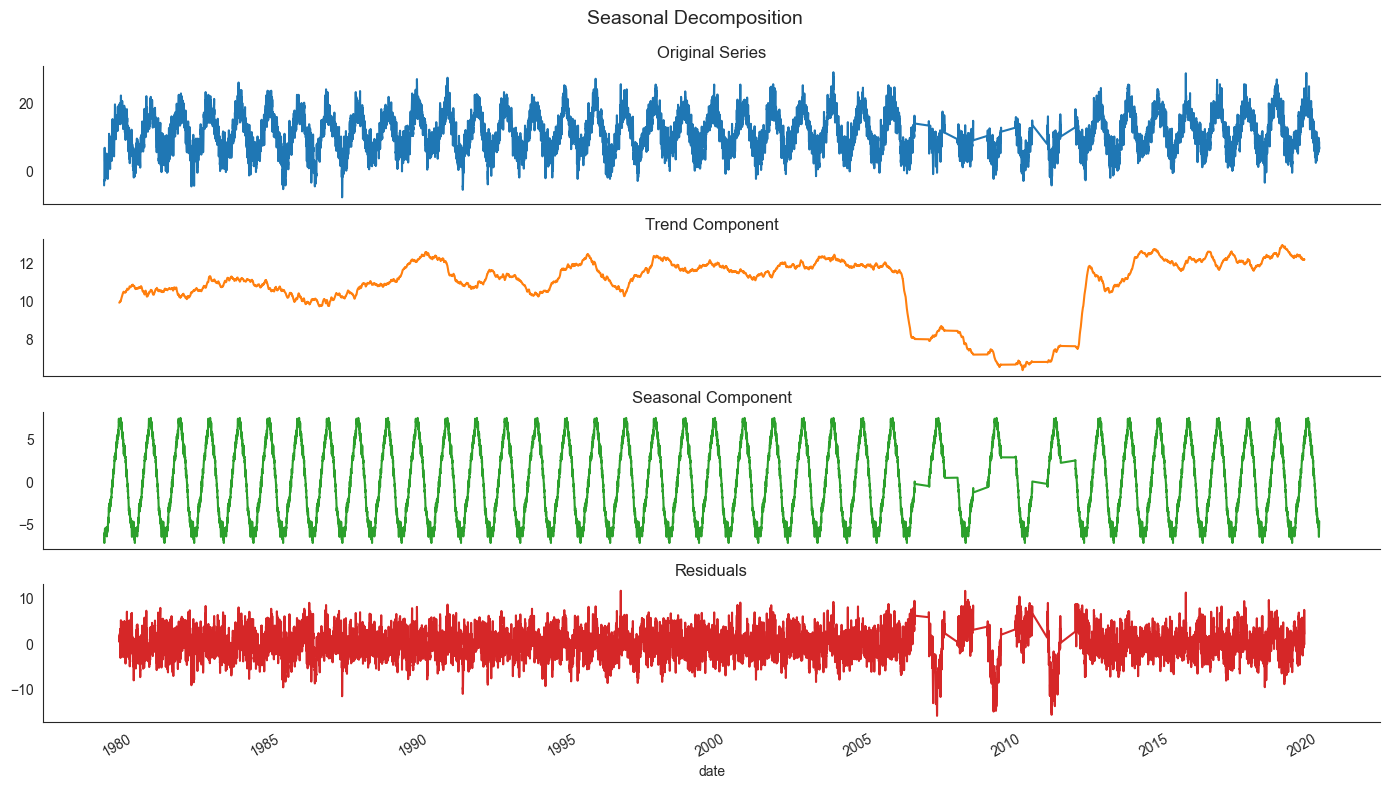

In [16]:
ts = (london_weather_df['mean_temp'].to_frame('Original')
      .assign(Trend=london_weather_components.trend)
      .assign(Seasonality=london_weather_components.seasonal)
      .assign(Residual=london_weather_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

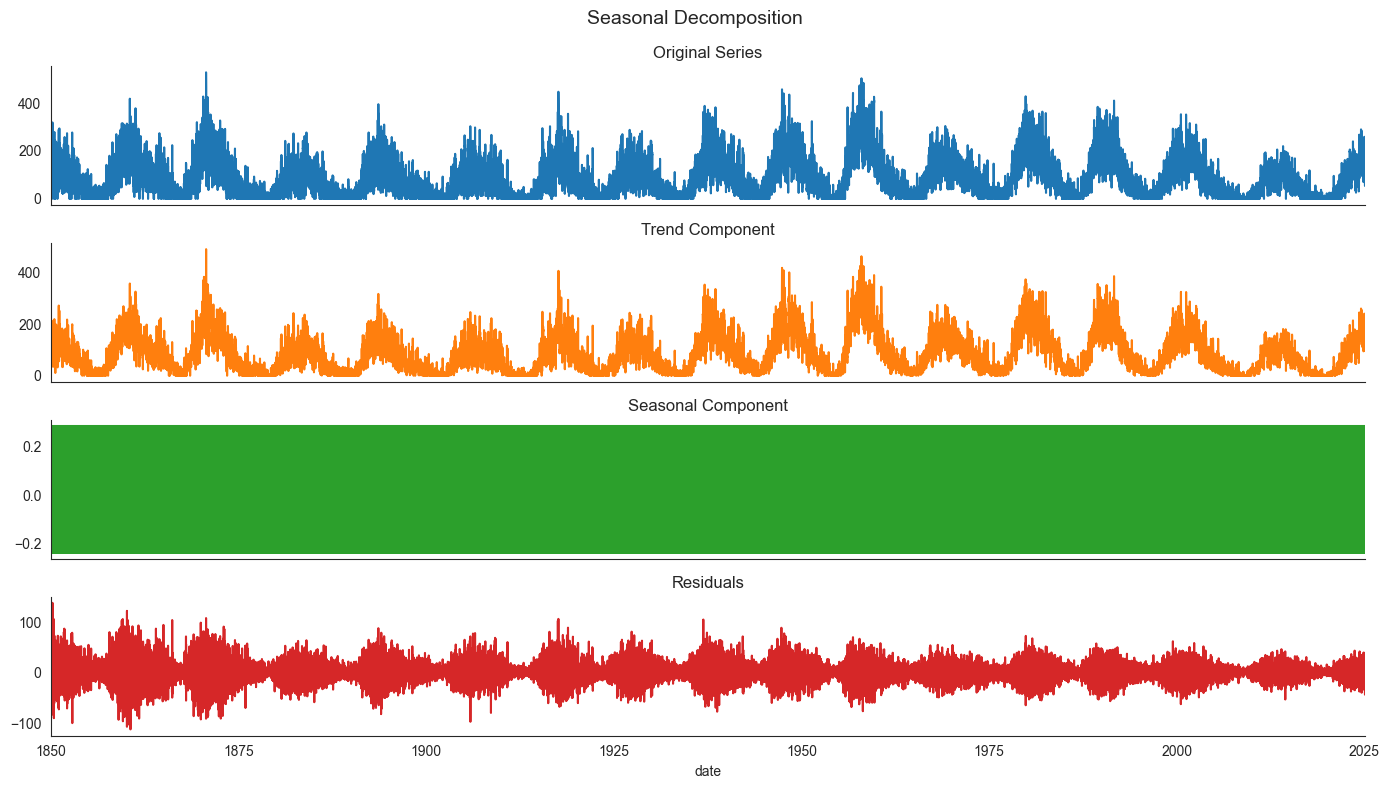

In [17]:
ts = (sunspot_df['counts'].to_frame('Original')
      .assign(Trend=sunspot_components.trend)
      .assign(Seasonality=sunspot_components.seasonal)
      .assign(Residual=sunspot_components.resid))
with sns.axes_style('white'):
    ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
    plt.suptitle('Seasonal Decomposition', fontsize=14)
    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(top=.91);

In [52]:
bitcoin_df['close_log'] = np.log(bitcoin_df['close'])
bitcoin_df['close_diff'] = bitcoin_df['close_log'].diff()
bitcoin_df.dropna(subset=['close_diff'], inplace=True)
bitcoin_df.head()
bitcoin_df.head()

,close,close_log,close_diff
datetime,,,
2024-07-25,65796,11.094314,0.006404
2024-07-26,67921,11.126101,0.031786
2024-07-27,67892,11.125673,-0.000427
2024-07-28,68264,11.131138,0.005464
2024-07-29,66780,11.109159,-0.021979


In [28]:
def log_and_diff(column, name):
    column_log = np.log(column)
    column_diff = column_log.diff().dropna()
    return column, column_log, column_diff
    
data_list = [(bitcoin_df['close'], 'bitcoin'),
             (sunspot_df['counts'], 'sunspot'),
             (air_passenger_df['#Passengers'], 'passengers'),
             (london_weather_df['mean_temp'], 'temperature')]

results = {}

for data, name in data_list:
    original, logged, differenced = log_and_diff(data, name)
    results[f'{name}_original'] = original
    results[f'{name}_logged'] = logged
    results[f'{name}_differenced'] = differenced   

In [39]:
print(type(results['sunspot_differenced']))

<class 'pandas.core.series.Series'>


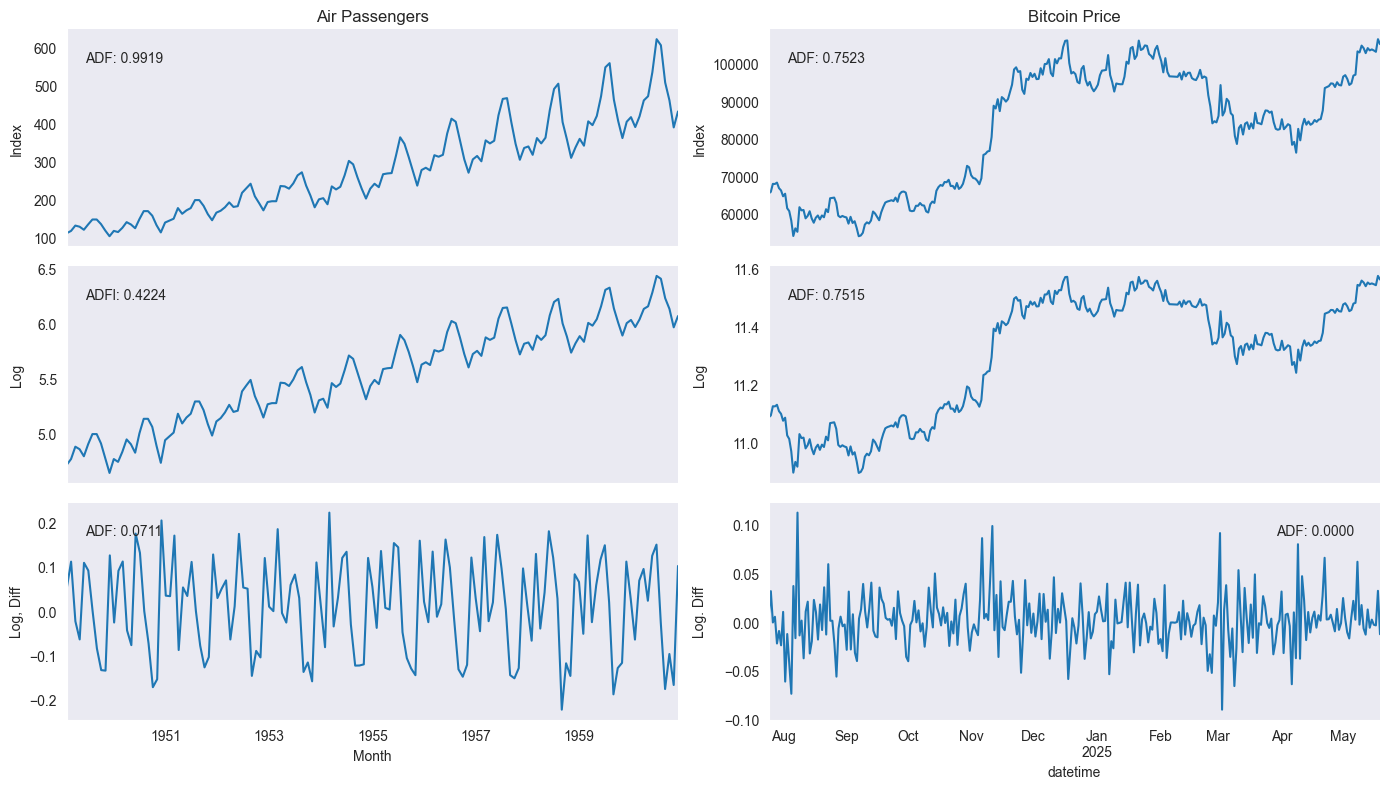

In [32]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    results['passengers_original'].plot(ax=axes[0][0],
                title='Air Passengers')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f"ADF: {tsa.adfuller(results['passengers_original'].dropna())[1]:.4f}",
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    results['passengers_logged'].plot(ax=axes[1][0])
    axes[1][0].text(x=.03, y=.85,
                    s=f"ADFl: {tsa.adfuller(results['passengers_logged'].dropna())[1]:.4f}",
                    transform=axes[1][0].transAxes)
    axes[1][0].set_ylabel('Log')

    results['passengers_differenced'].plot(ax=axes[2][0],
                         sharex=True)
    axes[2][0].text(x=.03, y=.85,
                    s=f"ADF: {tsa.adfuller(results['passengers_differenced'].dropna())[1]:.4f}",
                    transform=axes[2][0].transAxes)
    axes[2][0].set_ylabel('Log, Diff')

    results['bitcoin_original'].plot(ax=axes[0][1],
                               title='Bitcoin Price')
    axes[0][1].text(x=.03, y=.85,
                    s=f"ADF: {tsa.adfuller(results['bitcoin_original'])[1]:.4f}",
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    results['bitcoin_logged'].plot(ax=axes[1][1],
                                   sharex=True)
    axes[1][1].text(x=.03, y=.85,
                    s=f"ADF: {tsa.adfuller(results['bitcoin_logged'].dropna())[1]:.4f}",
                    transform=axes[1][1].transAxes)
    axes[1][1].set_ylabel('Log')

    results['bitcoin_differenced'].plot(ax=axes[2][1],
                                        sharex=True)
    axes[2][1].text(x=.83, y=.85,
                    s=f"ADF: {tsa.adfuller(results['bitcoin_differenced'].dropna())[1]:.4f}",
                    transform=axes[2][1].transAxes)
    axes[2][1].set_ylabel('Log. Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

In [36]:
print(results['sunspot_logged'].isna().sum())
print(np.isinf(results['sunspot_logged']).sum())
print(results['sunspot_logged'].var())  # Should not be 0
# Check for NaN and infinite values
print("Number of NaN values:", results['sunspot_logged'].isna().sum())
print("Number of inf/-inf values:", np.isinf(results['sunspot_logged']).sum())

# Check if the entire Series is NaN
print("Is the Series all NaN?", results['sunspot_logged'].isna().all())

0
9344
nan
Number of NaN values: 0
Number of inf/-inf values: 9344
Is the Series all NaN? False


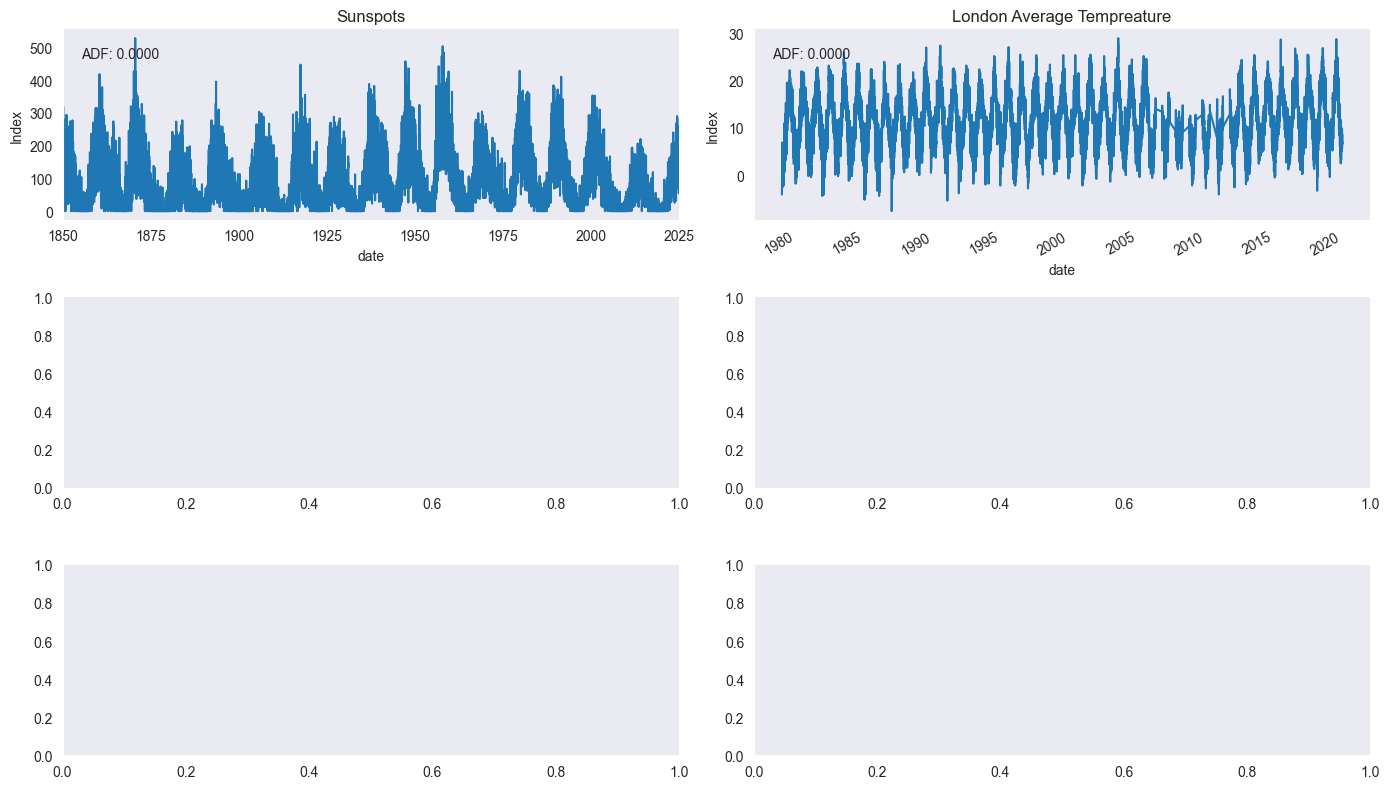

In [42]:
with sns.axes_style('dark'):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))

    results['sunspot_original'].plot(ax=axes[0][0],
                title='Sunspots')
    axes[0][0].text(x=.03,
                    y=.85,
                    s=f"ADF: {tsa.adfuller(results['sunspot_original'].dropna())[1]:.4f}",
                    transform=axes[0][0].transAxes)
    axes[0][0].set_ylabel('Index')

    # results['sunspot_logged'].plot(ax=axes[1][0])
    # axes[1][0].text(x=.03, y=.85,
    #                 s=f"ADFl: {tsa.adfuller(results['sunspot_logged'].dropna())[1]:.4f}",
    #                 transform=axes[1][0].transAxes)
    # axes[1][0].set_ylabel('Log')

    # results['sunspot_differenced'].plot(ax=axes[2][0],
    #                      sharex=True)
    # axes[2][0].text(x=.03, y=.85,
    #                 s=f"ADF: {tsa.adfuller(results['sunspot_differenced'].dropna())[1]:.4f}",
    #                 transform=axes[2][0].transAxes)
    # axes[2][0].set_ylabel('Log, Diff')

    results['temperature_original'].plot(ax=axes[0][1],
                               title='London Average Tempreature')
    axes[0][1].text(x=.03, y=.85,
                    s=f"ADF: {tsa.adfuller(results['temperature_original'])[1]:.4f}",
                    transform=axes[0][1].transAxes)
    axes[0][1].set_ylabel('Index')

    # results['temperature_logged'].plot(ax=axes[1][1],
    #                                sharex=True)
    # axes[1][1].text(x=.03, y=.85,
    #                 s=f"ADF: {tsa.adfuller(results['temperature_logged'].dropna())[1]:.4f}",
    #                 transform=axes[1][1].transAxes)
    # axes[1][1].set_ylabel('Log')

    # results['temperature_differenced'].plot(ax=axes[2][1],
    #                                     sharex=True)
    # axes[2][1].text(x=.83, y=.85,
    #                 s=f"ADF: {tsa.adfuller(results['temperature_differenced'].dropna())[1]:.4f}",
    #                 transform=axes[2][1].transAxes)
    # axes[2][1].set_ylabel('Log. Diff')
    sns.despine()
    fig.tight_layout()
    fig.align_ylabels(axes)

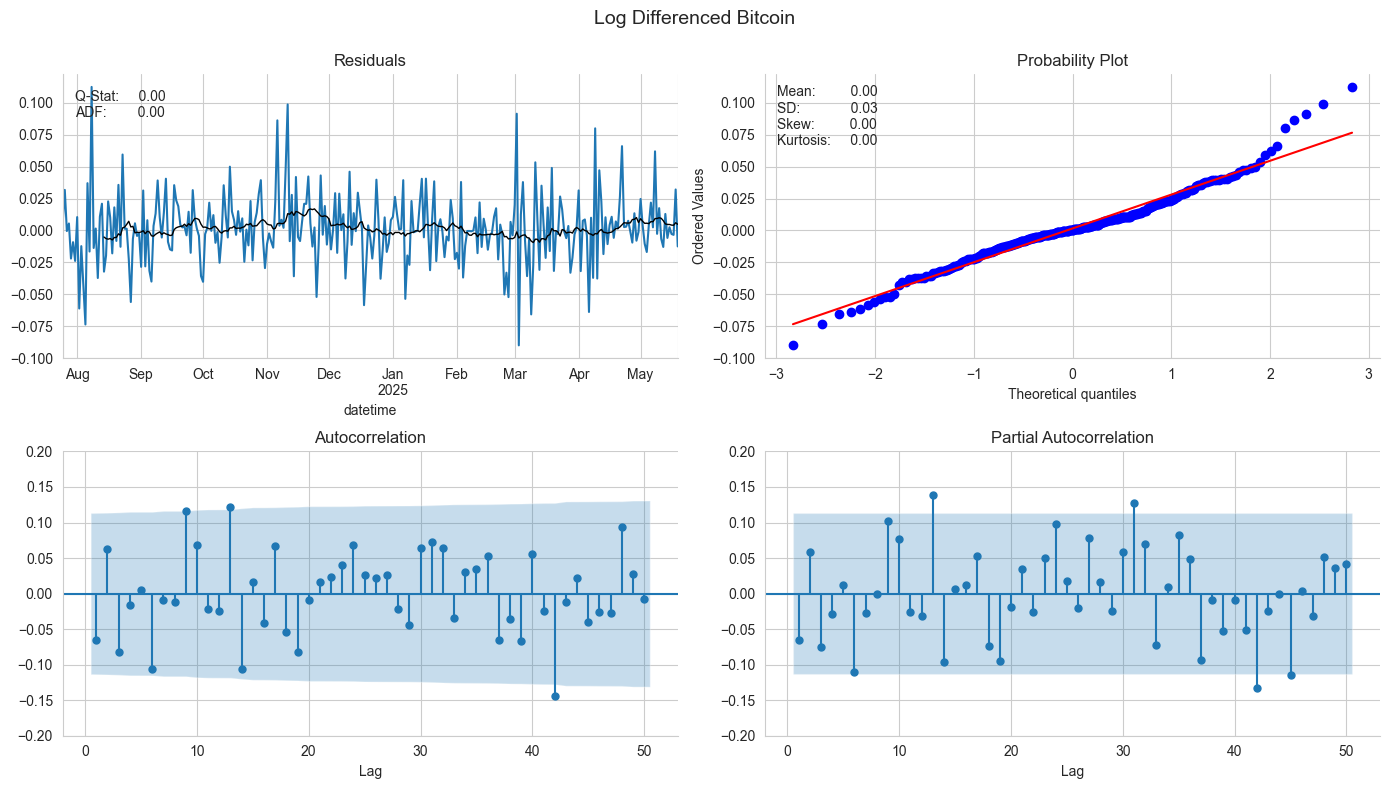

In [50]:
plot_correlogram(results['bitcoin_differenced'], lags=50, title='Log Differenced Bitcoin', ylim=(-0.2, 0.2))

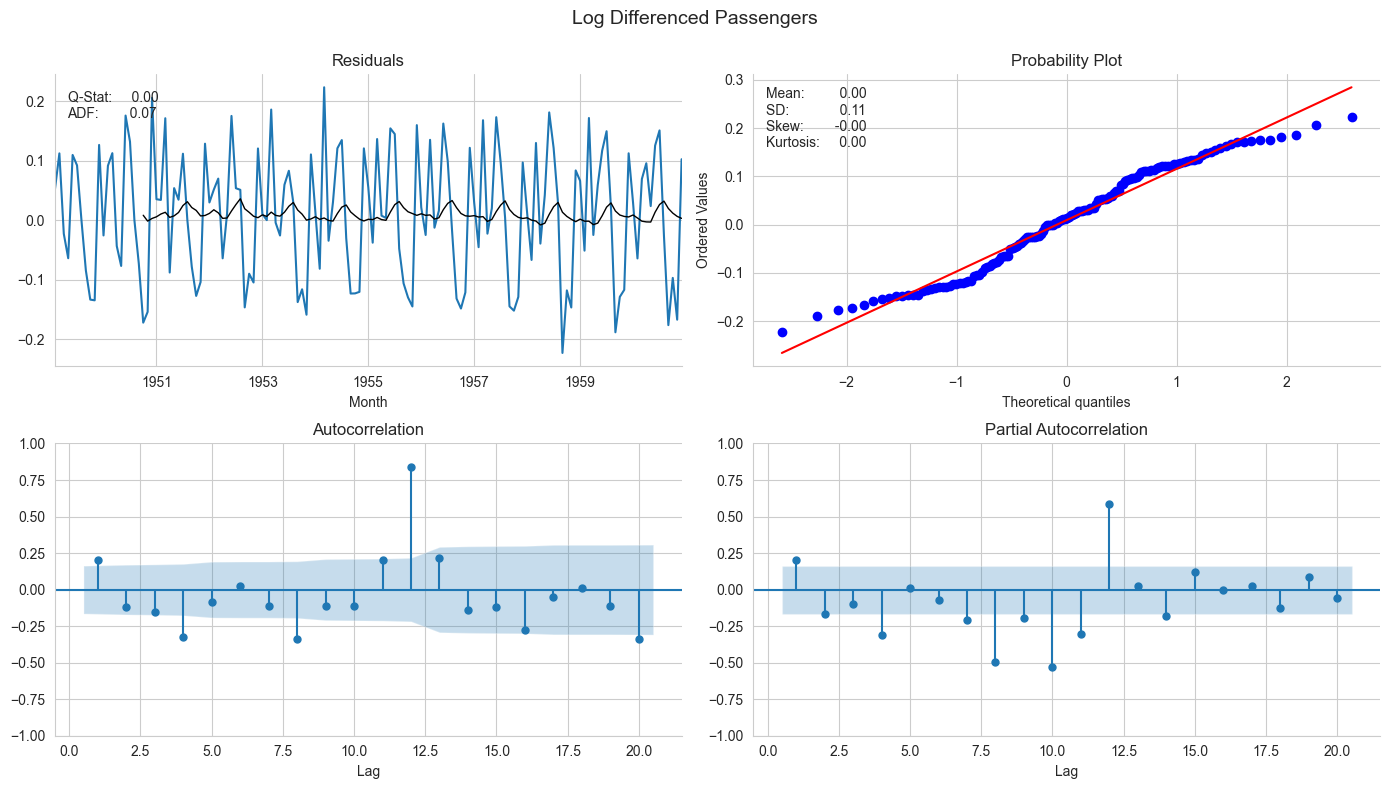

In [51]:
plot_correlogram(results['passengers_differenced'], lags=20, title='Log Differenced Passengers')